# map dashboard with bokeh and panel

## interactions

* selection of points: get selected dataframe
* get a tree from subset of samples
    - requires snp matrix for samples
    - use encoded snps in the database?
* show clustermap of snp distances
* draw map to show closely related isolates only
* draw selected samples from multiselect on map
* show SNP data?
* show movement type data?

In [29]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
import sqlite3
import toytree, toyplot
import random
from snipgenie import trees, app, tools, snp_typing


In [2]:
css = '''
.bk.panel-widget-box {
  background: #f0f0f0;
  border-radius: 5px;
  border: 1px black solid;
}
'''

In [3]:
from collections import OrderedDict
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Slider
from bokeh.plotting import figure
from bokeh.themes import Theme
from bokeh.io import show, output_notebook
from bokeh.models import (DataTable, GeoJSONDataSource, ColumnDataSource, HoverTool, renderers,
                          Label, LabelSet, CustomJS, MultiSelect, Dropdown, Div)
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension(raw_css=[css])

Loading BokehJS ...

In [4]:
tree_style = {
    "layout":'r',
    "edge_type": 'p',
    "edge_style": {
        "stroke": 'black',
        "stroke-width": 2,
    },
    "tip_labels": True,
    "tip_labels_align": True,
    "tip_labels_colors": 'black',
    "tip_labels_style": {
        "font-size": "14px"
    },
    "node_labels": False,
    "node_sizes": 10,
    "node_colors": toytree.colors[2],
    "node_markers":"c",
    "use_edge_lengths":True,
}

template = """
{% extends base %}

<!-- goes in body -->
{% block postamble %}
<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/css/bootstrap.min.css">
{% endblock %}

<!-- goes in body -->
{% block contents %}
{{ app_title }}
<p>This is a Panel app with a custom template allowing us to compose multiple Panel objects into a single HTML document.</p>
<br>
<div class="container">
  <div class="row">
    <div class="col-sm">
      {{ embed(roots.A) }}
    </div>
    <div class="col-sm">
      {{ embed(roots.B) }}
    </div>
  </div>
</div>
{% endblock %}
"""

In [5]:
def test_map():
    tile_provider = get_provider(CARTODBPOSITRON)
    # range bounds supplied in web mercator coordinates
    p = figure(x_range=(-2000000, 6000000), y_range=(-1000000, 7000000),
               x_axis_type="mercator", y_axis_type="mercator")
    p.add_tile(tile_provider)
    return p

#p=test_map()
#show(p)

In [6]:
species_colors = {'Cow':'green', 'Badger':'blue', 'Deer':'red'}
sb_colors = {'SB0054':'blue','SB0041':'green'}
clade_colors = {2:'yellow',3:'green'}
cmaps = {'species': species_colors,'spoligotype':sb_colors,'clade':clade_colors}
providers = ['CARTODBPOSITRON','STAMEN_TERRAIN','OSM','ESRI_IMAGERY']

In [7]:
def bokeh_map(df=None, long=None, lat=None,
              tile_provider='CARTODBPOSITRON', colorby='species',
              labels=None):
    """Bokeh map"""
    
    tile_provider = get_provider(tile_provider)
    tools = "pan,wheel_zoom,hover,tap,lasso_select,reset,save"
    sizing_mode='stretch_both'
    
    # range bounds supplied in web mercator coordinates
    k = 6378137
    if lat == None:
        lat = 53.2
    if long == None:
        long = -6.2

    #get coords
    x = long * (k * np.pi/180.0)
    y = np.log(np.tan((90 + lat) * np.pi/360.0)) * k
    df = wgs84_to_web_mercator(df, lon="LONG", lat="LAT")
    colormap = cmaps[colorby]
    df['color'] = [colormap[i] if i in colormap else 'gray' for i in df[colorby]]  
    source = ColumnDataSource(df)
    #draw figure
    p = figure(x_range=(x-100000, x+100000), y_range=(y-100000, y+100000),
               x_axis_type="mercator", y_axis_type="mercator", tools=tools,
               plot_width=500, plot_height=500, sizing_mode=sizing_mode)   
    p.add_tile(tile_provider)
    p.circle(x='x', y='y', size=15, alpha=0.7, color='color', source=source)#, legend_group=colorby)
    #if labels != None:       
    #    labels = LabelSet(x='x', y='y', text='name',
    #                      x_offset=5, y_offset=5, source=source, render_mode='canvas')
    p.toolbar.logo = None
    hover = p.select(dict(type=HoverTool))
    hover.tooltips = OrderedDict([
        ("name", "@name"),
        ("species", "@species"),
        ("spoligotype", "@spoligotype"),
        ("clade", "@clade"),     
        ("nearest", "@nearest"), 
        ("county", "@county"),
    ])
    return p

In [8]:
def wgs84_to_web_mercator(df, lon="LON", lat="LAT"):

      k = 6378137
      df["x"] = df[lon] * (k * np.pi/180.0)
      df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
      return df

## test data - should read from db later

In [9]:
df = pd.read_csv('ireland_test_data.csv')
p=bokeh_map(df)
show(p)

In [ ]:
#read from db
con = sqlite3.connect("test.sqlite")
cur = con.cursor()
df = pd.read_sql_query("SELECT * from isolates", con)

In [10]:
def sample_tree(n=10):

    import toytree
    tre = toytree.rtree.coaltree(n)
    ## assign random edge lengths and supports to each node
    for node in tre.treenode.traverse():
        node.dist = np.random.exponential(1)
        node.support = int(np.random.uniform(50, 100))

    canvas,axes,mark = tre.draw(
                    width=350,
                    height=500,
                    scalebar=True, **tree_style)
    toyplot.html.render(canvas, "tree.html")
    return

In [21]:
def get_tree(df):
    """get a tree from a selection of samples
       uses encoded snp data from dataframe/db to make a distance matrix
    """
    
    #decode snps
    snpmat = df.snps.apply(snp_typing.decode_snps)
    snpmat.index = df.name
    #print (snpmat[:4])
    #make tree
    tre = snp_typing.tree_from_snps(snpmat.T)
    #render to html
    canvas, axes, mark = tre.draw(width=400, height=400)    
    toyplot.html.render(canvas, "tree.html")
    return 

#get_tree(df)

In [64]:
def dist_matrix(df):
    """Distance matrix from nuc SNP matrix"""
    
    from difflib import SequenceMatcher        
    snpmat = df.snps.apply(snp_typing.decode_snps)
    names = snpmat.index = df.name
    M=[]
    for i,r in snpmat.iterrows():
        x=[]
        s1 = ''.join(r)
        for i,r in snpmat.iterrows():
            s2=''.join(r)
            seqm = (SequenceMatcher(None, s1, s2).ratio())
            #print (seqm)
            x.append(seqm)
        M.append(x)
    M = pd.DataFrame(M,index=names,columns=names)
    return M

dist_matrix(df[:4])

name       ERR125617  ERR125622  ERR125598  ERR125612
name                                                 
ERR125617   1.000000   1.000000   0.076174   0.084765
ERR125622   1.000000   1.000000   0.076174   0.084765
ERR125598   0.076174   0.076174   1.000000   0.076174
ERR125612   0.084765   0.084765   0.076174   1.000000

name       ERR125617  ERR125622  ERR125598  ERR125612  ERR125603  ERR125611  ERR125600  ERR125626  ERR125625  ERR125616
name                                                                                                                   
ERR125617   0.000000   0.000000   0.923826   0.915235   0.924971   0.000000   0.923826   0.924399   0.923826   0.923826
ERR125622   0.000000   0.000000   0.923826   0.915235   0.924971   0.000000   0.923826   0.924399   0.923826   0.923826
ERR125598   0.923826   0.923826   0.000000   0.923826   0.924971   0.923826   0.804124   0.924399   0.532646   0.923826
ERR125612   0.915235   0.915235   0.923826   0.000000   0.924971   0.915235   0.923826   0.924399   0.923826   0.923826
ERR125603   0.924971   0.924971   0.924971   0.924971   0.000000   0.924971   0.924971   0.924971   0.924971   0.924971
ERR125611   0.000000   0.000000   0.923826   0.915235   0.924971   0.000000   0.923826   0.924399   0.923826   0.923826
ERR125600   0.923826   0.923826   0.8041

/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:629: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


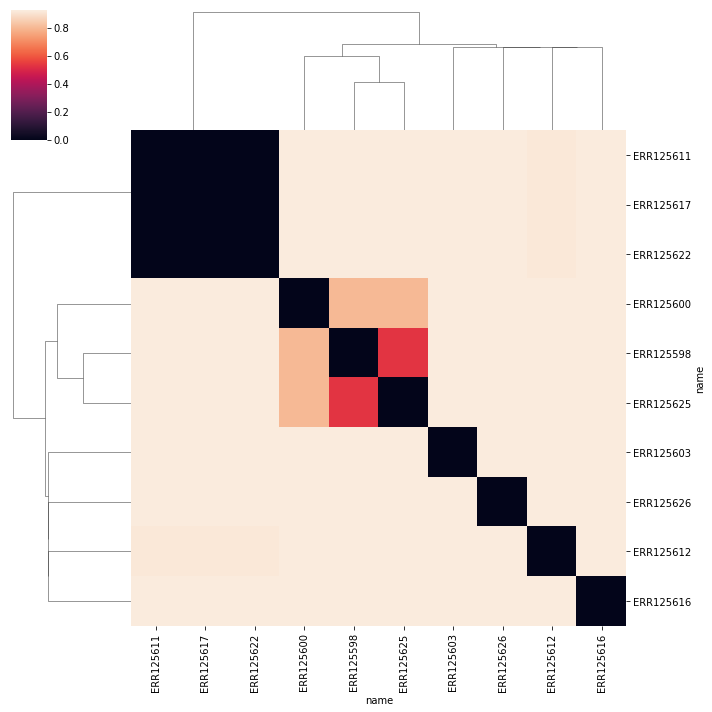

In [63]:
import seaborn as sns
m=dist_matrix(df[:10])
print (m)
sns.clustermap(m)

In [12]:
style1 = {'background':'lightgray','padding':'5px','font':'monospace'}

In [18]:
def map_dash():
    """Map dashboard"""

    names = list(df.name.unique())
    cols = df.columns[:6]
    cats=['species','clade','spoligotype','county']
    map_pane = pn.pane.Bokeh(width=400)
    tree_pane = pn.pane.HTML(width=300)
    sample_tree()
    tile_select = pnw.Select(name='tile layer',options=providers,width=200)    
    colorby_select = pnw.Select(name='color by',options=cats,width=200)
    label_select = pnw.Select(name='label',options=['']+cats,width=200)
    name_select = pnw.MultiSelect(name='name',options=names,size=4,width=200)   
    btn = pnw.Button(name='Reset', button_type='primary',width=200)
    info_pane = pn.pane.HTML(style=style1,width=200, sizing_mode='stretch_both')
    df_pane = pn.pane.DataFrame(df[cols],height=200,sizing_mode='scale_both',max_rows=6)
    empty_pane = pn.pane.HTML(width=300,style=style1,sizing_mode='scale_height')
    empty_pane.object = 'lskdklasdlkjsad'
    
    def update1(attr,new,old):     
        #print(new,old)
        info_pane.object = '<p>%s,%s</p>' %(int(new),int(old))
        
    def items_selected(event):
        items = name_select.value
        info_pane.object = ','.join(items)
        p = map_pane.object
        source = p.renderers[1].data_source
        sel = df[df.name.isin(items)]
        df_pane.object = sel[cols]
        #show these points only on map
        source.data = dict(sel)
        #get a tree
        if len(sel)>=3:
            get_tree(sel)
            tree_pane.object = open('tree.html','r').read()
        return
    
    def points_selected(attr,new,old):
        #print (new)
        ind =[int(n) for n in new]
        #for n in new:            
        #     info_pane.object = '<p>%s</p>' %n
        sel = df.loc[ind]
        df_pane.object = sel[cols]
        
        #get nearest
        if len(sel)>0:
            #print (found.iloc[0].nearest)
            s = sel.iloc[0].nearest
            near = s.split()
            info_pane.object = s
        if len(sel)>=3:
            get_tree(sel)
            tree_pane.object = open('tree.html','r').read()
        return
    
    def draw_map(event):
        p = map_pane.object = bokeh_map(df)  
        p.x_range.on_change('start', update1)
        source = p.renderers[1].data_source
        source.selected.on_change('indices', points_selected)   
        tree_pane.object = '' 
        return
    
    def update_map(event):         
        p = map_pane.object
        source = p.renderers[1].data_source
        p.renderers = [x for x in p.renderers if not str(x).startswith('TileRenderer')]            
        #p.add_tile(tile_select.value)
        rend = renderers.TileRenderer(tile_source= get_provider(tile_select.value))
        p.renderers.insert(0, rend) 
        colorby = colorby_select.value
        info_pane.object = '<p>%s,%s</p>' %(p.x_range.start,p.x_range.end)
        if label_select.value != '':
            #remove old labels?
            
            labels = LabelSet(x='x', y='y', text=label_select.value,
                         x_offset=5, y_offset=5, source=source, render_mode='canvas')
            p.add_layout(labels)
        return
    
    def update_tree(event):
        sample_tree()
        tree_pane.object = open('tree.html','r').read()
        
    draw_map(None)
    btn.on_click(draw_map)
    #label_box = pnw.Checkbox(name='Show labels')
    tile_select.param.watch(update_map,'value')
    colorby_select.param.watch(update_map,'value')
    label_select.param.watch(update_map,'value')
    name_select.param.watch(items_selected,'value')
    
    #layout dashboard
    app = pn.Column(pn.Row(pn.Column(tile_select,colorby_select,label_select,name_select,btn,info_pane,sizing_mode='stretch_height'),
                           pn.Column(map_pane,width=600),tree_pane),pn.Column(df_pane,empty_pane))
    return app

app = map_dash()

In [19]:
app

Column
    [0] Row
        [0] Column(sizing_mode='stretch_height')
            [0] Select(name='tile layer', options=['CARTODBPOSITRON', ...], value='CARTODBPOSITRON', width=200)
            [1] Select(name='color by', options=['species', 'clade', ...], value='species', width=200)
            [2] Select(name='label', options=['', 'species', ...], width=200)
            [3] MultiSelect(name='name', options=['ERR125617', ...], width=200)
            [4] Button(button_type='primary', name='Reset', width=200)
            [5] HTML(None, sizing_mode='stretch_both', style={'background': 'lightgray'...}, width=200)
        [1] Column(width=600)
            [0] Bokeh(Figure, width=400)
        [2] HTML(str, width=300)
    [1] Column
        [0] DataFrame(DataFrame, height=200, max_rows=6, sizing_mode='scale_both')
        [1] HTML(str, sizing_mode='scale_height', style={'background': 'lightgray'...}, width=300)